The roots of probabilistic graphical models go back to the 1980s, with a strong connection to Bayesian statistics. The story resembles that of neural networks: they have been around for over three decades and they need massive computational power. However, unlike in the case of deep learning, the requirements fo computational resources remain out of reach. These models require sampling a distribution, and very often it is the Boltzmann distribution. Since quantum computers can give samples from this distribution, we can hope that quantum hardware can enable these models the same way graphics processing units enabled deep learning.

# Probabilistic graphical models

Probabilistic graphical models capture a compact representation of a joint probability distribution. For $\{X_1,\ldots,X_N\}$ binary random variables, there are $2^N$ assignments. In a graphical model, complexity is dealt through graph theory. We get both an efficient treatment of uncertainty (probabilities) and of logical structure (independence constraints). The factorization of the probabilities happens along conditional independences among random variables. The definition is that $X$ is conditionally independent of $Y$ given $Z$ $(X\perp Y|Z)$, if $P(X=x, Y=y|Z=z) = P(X=x|Z=z)P(Y=y|Z=z)$ for all $x\in X,y\in Y,z\in Z$.

The graph can be directed -- these are called Bayesian networks in general -- or undirected, in the case of Markov networks (also known as Markov random fields) [[1](#1)]. Graphical models are quintessentially generative: we explicitly model a probability distribution. Thus generating new samples is trivial and we can always introduce extra random variables to ensure certain properties. These models also take us a step closer to explainability, either by the use of the random variables directly for explanations (if your model is such) or by introducing explanatory random variables that correlate with the others.

In a Markov random field, we can allow cycles in the graph and switch from local normalization (conditional probability distribution at each node) to global normalization of probabilities (i.e. a partition function). Examples include countless applications in computer vision, pattern recognition, artificial intelligence, but also Ising models that we have seen before: the factors are defined as degree-1 and degree-2 monomials of the random variables connected in the graph.

The factorization is given as a sum $P(X_1, \ldots, X_N) = \frac{1}{Z}\exp(-\sum_i E[C_k])$, where $C_k$ are are cliques of the graph, and $E[.]$ is an energy defined over the cliques. If $P$ is a Boltzmann distribution over $G$, all local Markov properties will hold. The other way also holds if $P$ is a positive distribution.

Let us define a Markov random field of binary variables. This will be a random Ising model over a three nodes. This will contain three cliques of a single node (the on-site fields) and two cliques of two nodes: the edges that connect the nodes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import dimod

n_spins = 3
h = {v: np.random.uniform(-2, 2) for v in range(n_spins)}
J = {(0, 1): np.random.uniform(-1, 1),
     (1, 2): np.random.uniform(-1, 1)}
model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
sampler = dimod.SimulatedAnnealingSampler()        

The probability distribution of a configuration $P(X_1, \ldots, X_N) = \frac{1}{Z}\exp(-\sum_i E[C_k])$ does not explicitly define the temperature, but it is implicitly there in the constants defining the Hamiltonian. So, for instance, we can scale it a temperature $T=1$

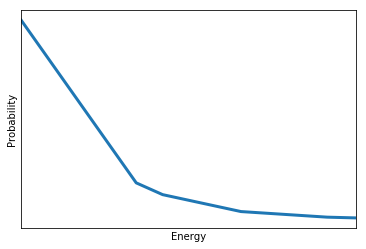

In [2]:
temperature = 1
response = sampler.sample(model, beta_range=[1/temperature, 1/temperature], num_reads=100)
energies = [solution.energy for solution in response.data()]
fig, ax = plt.subplots()
probabilities = np.exp(-np.array(sorted(energies))/temperature)
Z = probabilities.sum()
probabilities /= Z
ax.plot(energies, probabilities, linewidth=3)
ax.set_xlim(min(energies), max(energies))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Energy')
ax.set_ylabel('Probability')
plt.show()

In this case, the conditional independences are already encapsulated by the model: for instances, spins 0 and 2 do not interact. In general, it is hard to learn the structure of a probabilistic graphical given a set of observed correlations in the sample $S$. We can only rely on heuristics. The typical way of doing it is to define a scoring function and do some heuristic global optimization. 

Once we identified or defined the graph structure $G$, we have to learn the probabilities in the graph. We again rely on our sample and its correlations, and use a maximum likelihood or a maximum a posteriori estimate of the corresponding parameters $\theta_G$ with the likelihood $P(S|\theta_G)$. This is again a hard problem.

Applying the learned model means probabilistic inference to answer queries of the following types:

-   Conditional probability: $P(Y|E=e)=\frac{P(Y,e)}{P(e)}$.

-   Maximum a posteriori:
    $\mathrm{argmax}_y P(y|e)=\mathrm{argmax}_y \sum_Z P(y, Z|e)$.

This problem is in \#P. Contrast this to deep learning: once the neural network is trained, running a prediction on it is relatively cheap. In the case of probabilistic graphical models, inference remains computationally demanding even after training the model. Instead of solving the inference problem directly, we use approximate inference with sampling, which is primarily done with Monte Carlo methods on a classical computer. These have their own problems of slow burn-in time and correlated samples, and this is exactly the step we can replace by sampling on a quantum computer.

For instance, let us do a maximum a posteriori inference on our Ising model. We clamp the first spin to -1 and run simulated annealing for the rest of them to find the optimal configuration. We modify the simulated annealing routine in `dimod` to account for the clamping.

In [3]:
from dimod.reference.samplers.simulated_annealing import greedy_coloring

clamped_spins = {0: -1}
num_sweeps = 1000
βs = [1.0 - 1.0*i / (num_sweeps - 1.) for i in range(num_sweeps)]

# Set up the adjacency matrix.
adj = {n: set() for n in h}
for n0, n1 in J:
    adj[n0].add(n1)
    adj[n1].add(n0)
# Use a vertex coloring for the graph and update the nodes by color
__, colors = greedy_coloring(adj)

spins = {v: np.random.choice((-1, 1)) if v not in clamped_spins else clamped_spins[v]
         for v in h}
for β in βs:
    energy_diff_h = {v: -2 * spins[v] * h[v] for v in h}

    # for each color, do updates
    for color in colors:
        nodes = colors[color]
        energy_diff_J = {}
        for v0 in nodes:
            ediff = 0
            for v1 in adj[v0]:
                if (v0, v1) in J:
                    ediff += spins[v0] * spins[v1] * J[(v0, v1)]
                if (v1, v0) in J:
                    ediff += spins[v0] * spins[v1] * J[(v1, v0)]

            energy_diff_J[v0] = -2. * ediff
        for v in filter(lambda x: x not in clamped_spins, nodes):
            logp = np.log(np.random.uniform(0, 1))
            if logp < -1. * β * (energy_diff_h[v] + energy_diff_J[v]):
                spins[v] *= -1

Running this algorithm, we can the most likely configuration:

In [4]:
spins

{0: -1, 1: -1, 2: 1}

# Boltzmann machines

A Boltzmann machine generates samples from a probability distributition $P(\textbf{v})$ inferred from the data, where $\textbf{v} \in \{0,1\}^n$. The assumption is that this distribution lies on a latent space that can be paramerized by a set of hidden variables $\textbf{h} \in \{0,1\}^n$, such that $P(\textbf{v})=\sum_h P(\textbf{v}|\textbf{h})P(\textbf{h})$. The joint probability distribution is modeled as a Gibbs distribution with the energy defined by an Ising Model: $P(\textbf{v}, \textbf{h})=\frac{1}{Z} e^{-\beta E(\textbf{h},\textbf{v})}$ and $E(\textbf{h},\textbf{v})=-\sum_{i,j} W_{ij} h_i v_j$. It can then be shown that $p(\textbf{h}|\textbf{v})=\sigma(W \cdot \textbf{v})$ and $p(\textbf{v}|\textbf{h})=\sigma(W \cdot \textbf{h})$, where $\sigma$ is the sigmoid function defined by $\sigma(x)=\frac{1}{1+e^{-x}}$.

To train a Boltzmann machine, we look for the weights $W$ that maximizes the log-likelihood $L=\sum_{\textbf{v} \in S} \log(p(\textbf{v}|W))$, where $S$ is the training set. This function can be optimized using regular gradient ascent: $W_{ij}^{(t+1)}=W_{ij}^{(t)} + \eta \frac{\partial L}{\partial W_{ij}}$. Computing the gradient $\frac{\partial L}{\partial W_{ij}}$ is the hard part. Indeed, we can show that 

$$\frac{\partial L}{\partial W_{ij}}=\frac{1}{|S|} \sum_{\textbf{v} \in S} \mathbb{E}_{\textbf{h} \sim P(\textbf{h}|\textbf{v})}[h_i v_j] - \mathbb{E}_{(\textbf{h},\textbf{v}) \sim P(\textbf{h},\textbf{v})}[h_i v_j]$$.

The first expectation value is easy to compute: it is equal to $\sigma \left( \sum_j W_{ij} v_j \right) v_j$. We only need to sum those expectation values over the dataset. This is called the positive phase, after its positive sign in the gradient.

The second expectation value cannot be simplified as easily, since it is taken over all possible configuration $\textbf{v}$ and $\textbf{h}$. It would take an exponential amount of time to compute it exactly. We can use the exact same quantum sampling method as above to outsource this part of the calculation to a quantum processing unit and train Boltzmann machines.

# References

[1] Koller, D., Friedman, N., Getoor, L., Taskar, B. (2007). [Graphical Models in a Nutshell](https://ai.stanford.edu/~koller/Papers/Koller+al:SRL07.pdf). In *Introduction to Statistical Relational Learning*, MIT Press. <a id='1'></a>